In [1]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from pathlib import Path

# add code directory to path
import sys
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from functools import partial
from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from torch_perturb.perturbations import perturbed
from torch_models import torch_bpr_uncurried, deterministic_bpr
from matplotlib import pyplot as plt


2025-01-20 01:15:06.970376: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 01:15:07.009603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 01:15:07.009635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 01:15:07.010556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 01:15:07.017378: I tensorflow/core/platform/cpu_feature_guar

In [2]:

def load_data(data_dir):
    """Load and process training, validation, and test data."""
    # Load data
    train_X_df = pd.read_csv(os.path.join(data_dir, 'train_x.csv'), index_col=[0,1])
    train_Y_df = pd.read_csv(os.path.join(data_dir, 'train_y.csv'), index_col=[0,1])
    val_X_df = pd.read_csv(os.path.join(data_dir, 'valid_x.csv'), index_col=[0,1])
    val_Y_df = pd.read_csv(os.path.join(data_dir, 'valid_y.csv'), index_col=[0,1])
    test_X_df = pd.read_csv(os.path.join(data_dir, 'test_x.csv'), index_col=[0,1])
    test_Y_df = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), index_col=[0,1])
    
    def convert_df_to_3d_array(df):
        geoids = sorted(df.index.get_level_values('geoid').unique())
        timesteps = sorted(df.index.get_level_values('timestep').unique())
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        num_features = len(df.columns)
        X = np.zeros((num_timesteps, num_locations, num_features))
        
        for (geoid, timestep), row in df.iterrows():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            X[t_idx, g_idx, :] = row.values
            
        return X, geoids, timesteps

    def convert_y_df_to_2d_array(y_df, geoids, timesteps):
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        y = np.zeros((num_timesteps, num_locations))
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        for (geoid, timestep), value in y_df.iloc[:, 0].items():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            y[t_idx, g_idx] = value
            
        return y

    # Process training data
    train_X, geoids, timesteps = convert_df_to_3d_array(train_X_df)#.drop(columns='timestep.1'))
    train_time = np.array([timesteps] * len(geoids)).T
    train_y = convert_y_df_to_2d_array(train_Y_df, geoids, timesteps)

    # Process validation data
    val_X, val_geoids, val_timesteps = convert_df_to_3d_array(val_X_df)#.drop(columns='timestep.1'))
    val_time = np.array([val_timesteps] * len(val_geoids)).T
    val_y = convert_y_df_to_2d_array(val_Y_df, val_geoids, val_timesteps)

    # Process test data
    test_X, test_geoids, test_timesteps = convert_df_to_3d_array(test_X_df)#.drop(columns='timestep.1'))
    test_time = np.array([test_timesteps] * len(test_geoids)).T
    test_y = convert_y_df_to_2d_array(test_Y_df, test_geoids, test_timesteps)

    return {
        'train': (torch.tensor(train_X, dtype=torch.float32), 
                 torch.tensor(train_time, dtype=torch.float32),
                 torch.tensor(train_y, dtype=torch.float32)),
        'val': (torch.tensor(val_X, dtype=torch.float32),
               torch.tensor(val_time, dtype=torch.float32),
               torch.tensor(val_y, dtype=torch.float32)),
        'test': (torch.tensor(test_X, dtype=torch.float32),
                torch.tensor(test_time, dtype=torch.float32),
                torch.tensor(test_y, dtype=torch.float32))
    }

In [5]:
location = 'cook'

dirs = {'MA': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'),
        'cook': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/cook', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/cook/'),}
data_dir, base_dir = dirs[location]
# Find all experiment directories
exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

device = 'cuda'
K=100
data = load_data(data_dir)

# Move data to device
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])


num_ranking_samples = 1000
num_trials = 1000

Processing experiment 0 of 189
Processing experiment 25 of 189
Processing experiment 50 of 189
Processing experiment 75 of 189
Processing experiment 100 of 189
Processing experiment 125 of 189
Processing experiment 150 of 189
Processing experiment 175 of 189


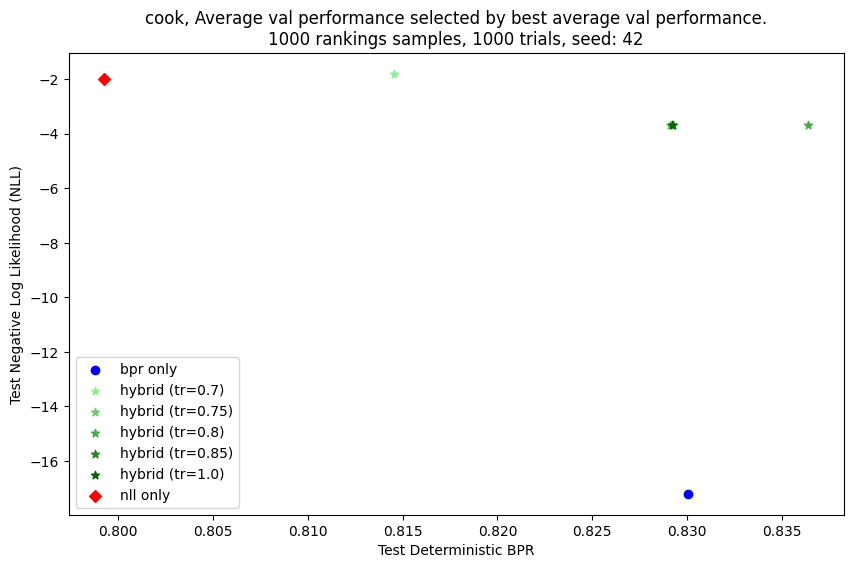

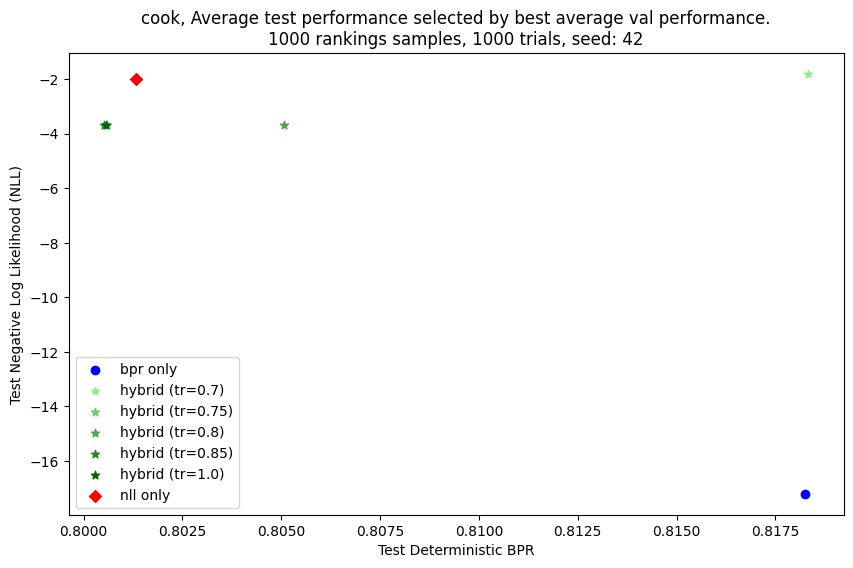

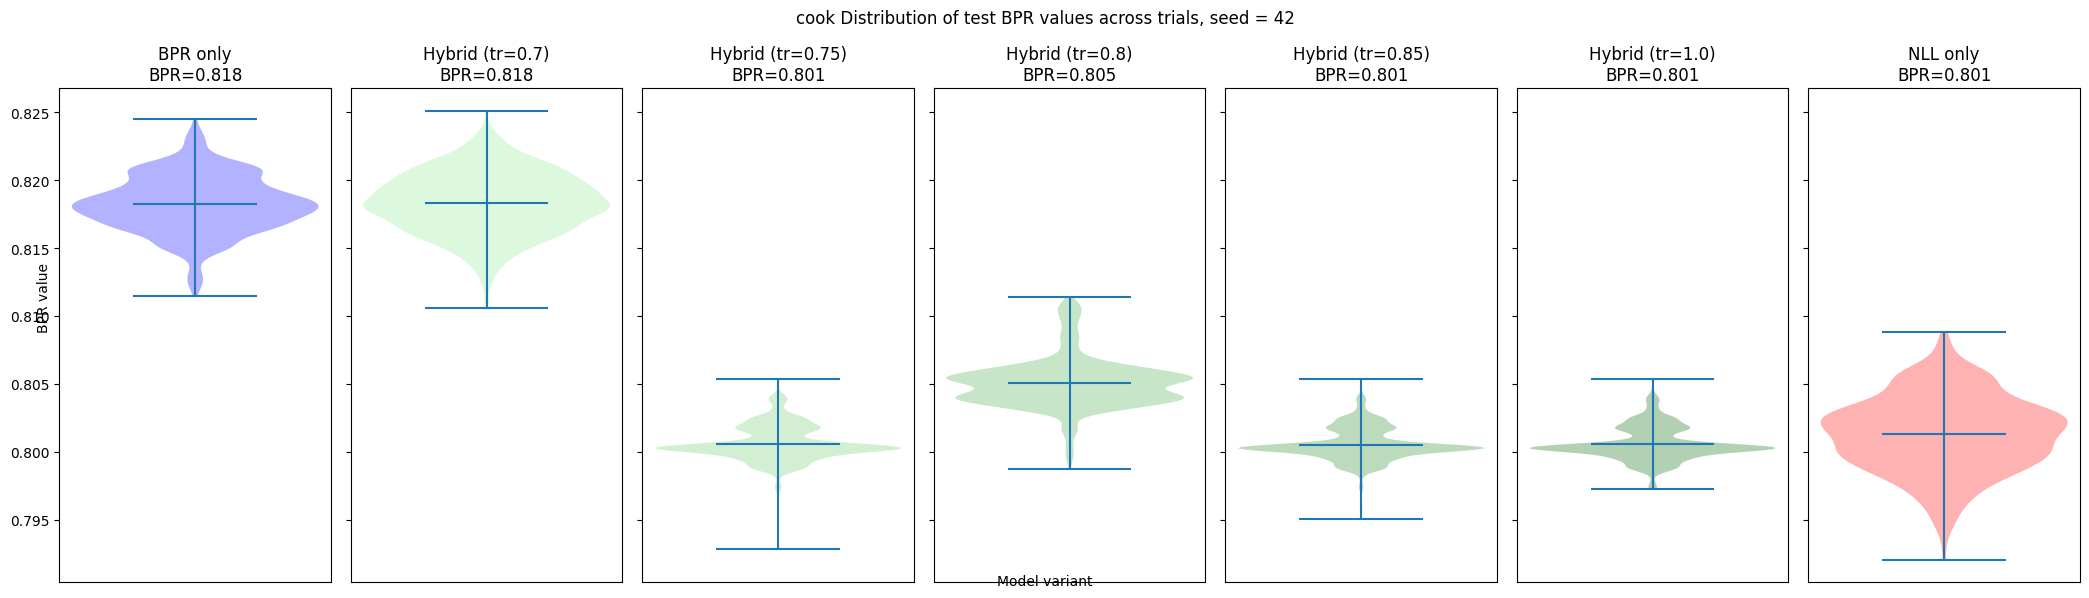

Processing experiment 0 of 189
Processing experiment 25 of 189
Processing experiment 50 of 189
Processing experiment 75 of 189
Processing experiment 100 of 189
Processing experiment 125 of 189
Processing experiment 150 of 189
Processing experiment 175 of 189


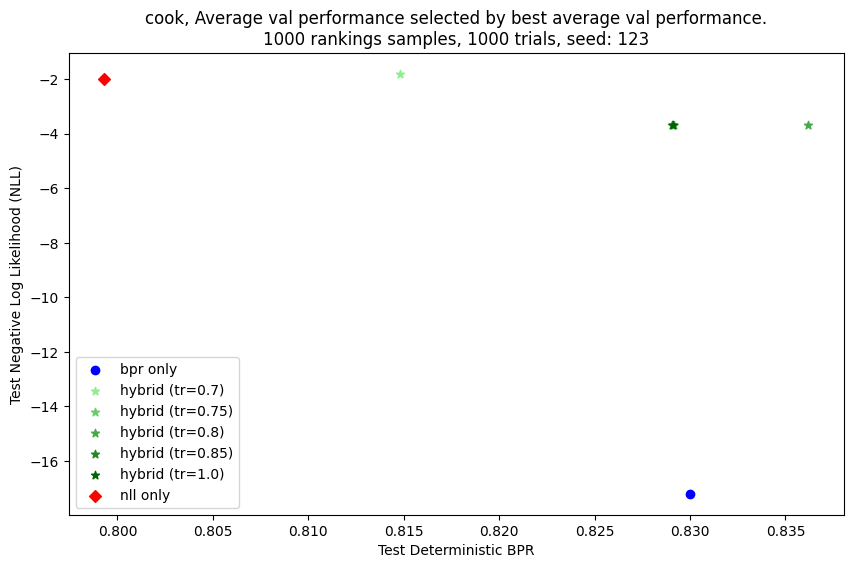

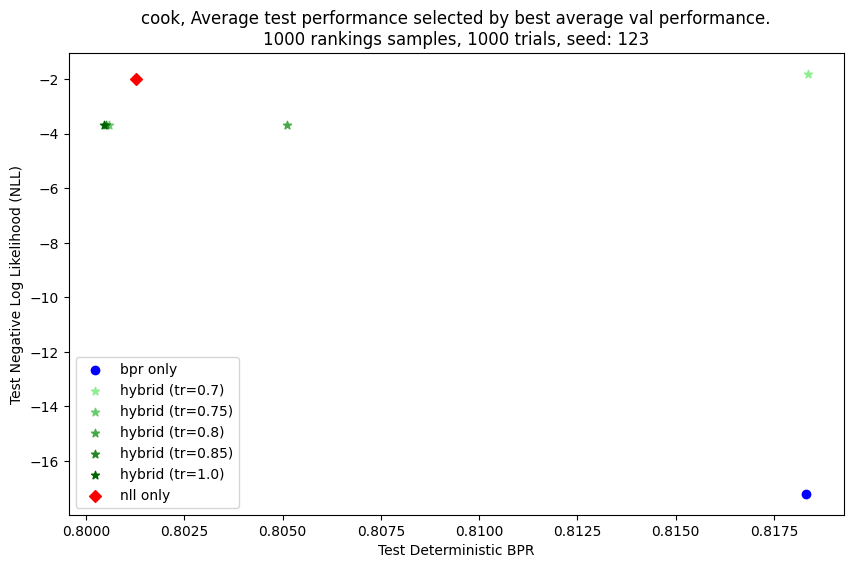

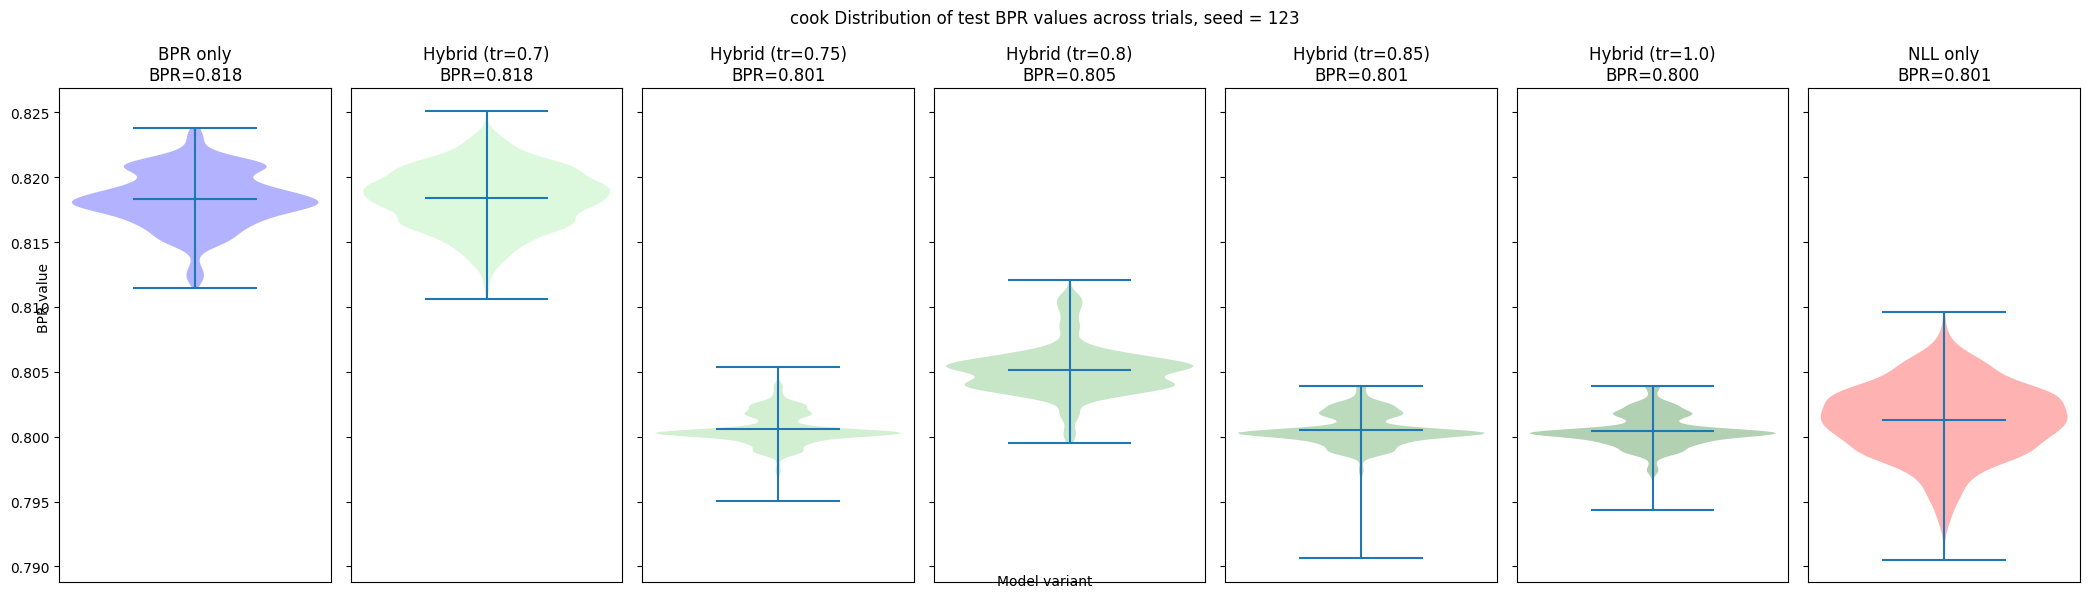

Processing experiment 0 of 189
Processing experiment 25 of 189
Processing experiment 50 of 189
Processing experiment 75 of 189
Processing experiment 100 of 189
Processing experiment 125 of 189
Processing experiment 150 of 189
Processing experiment 175 of 189


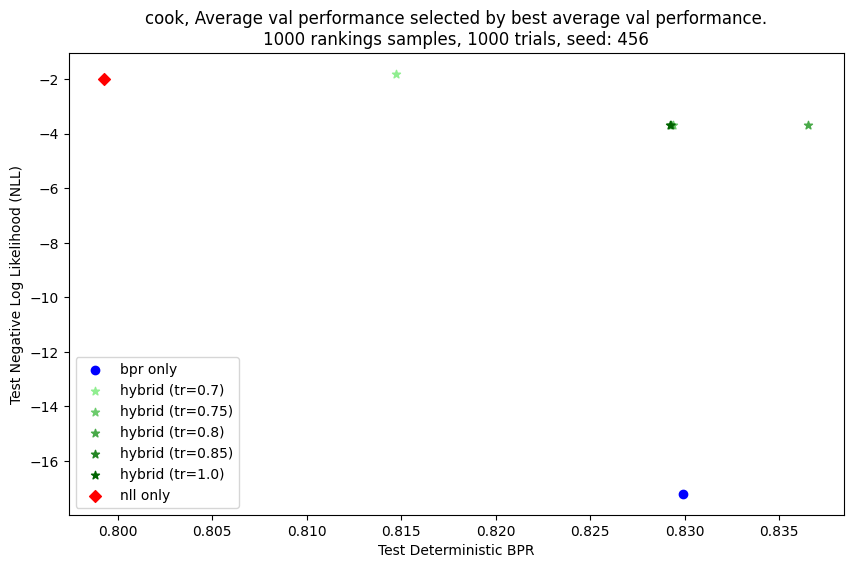

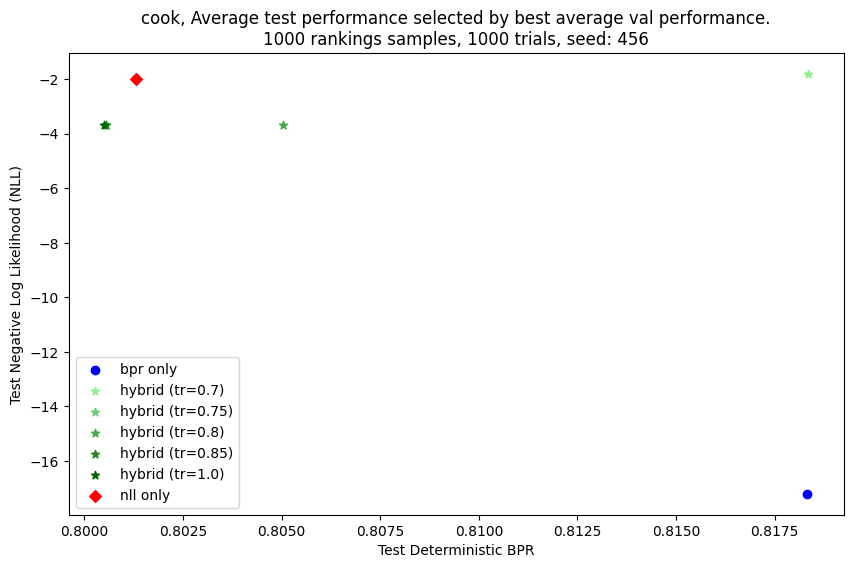

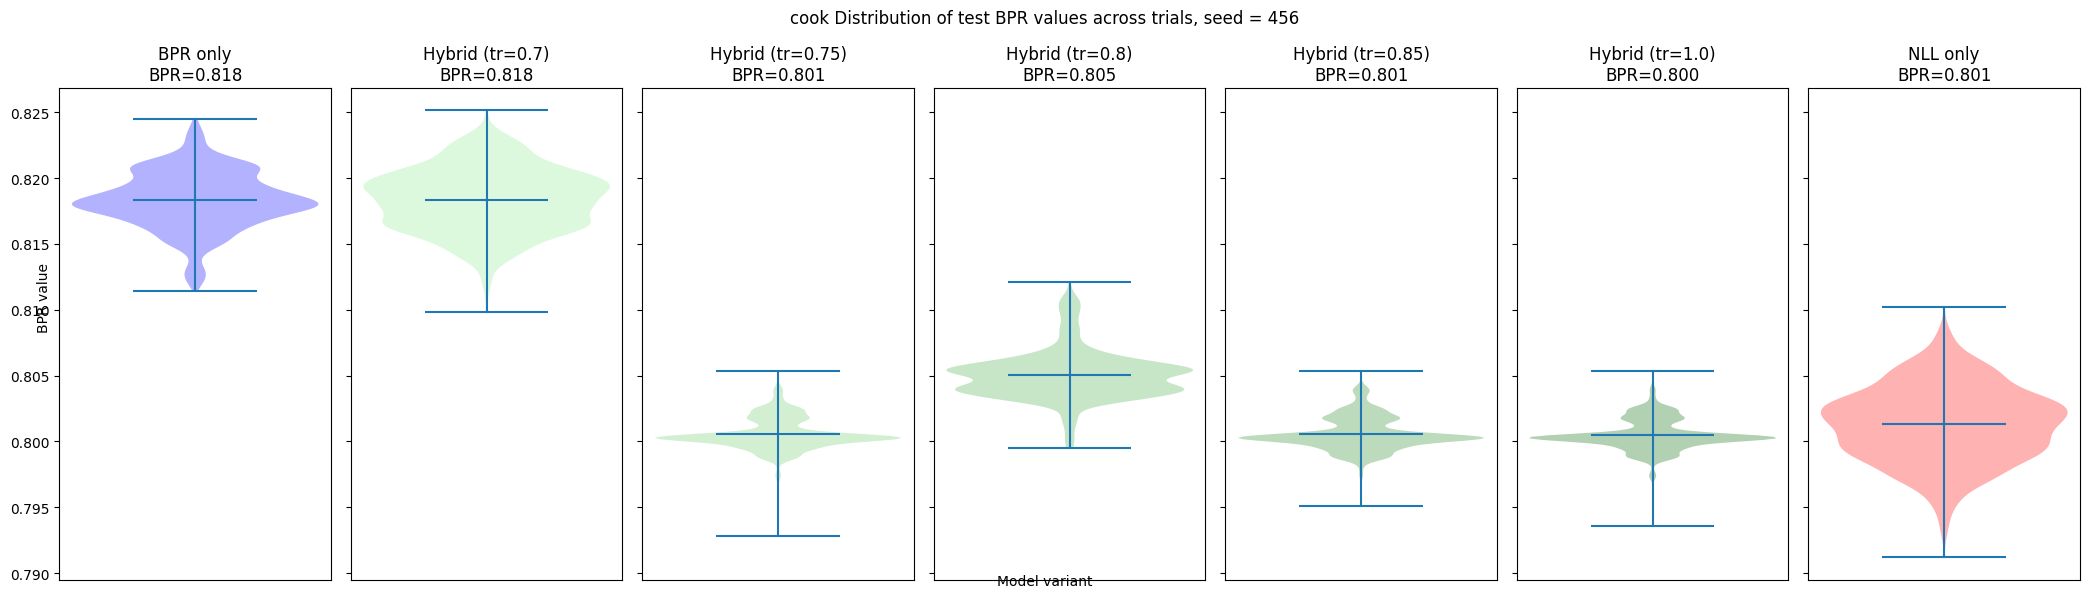

In [6]:
import os
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to run the experiment with a given seed
def run_experiment(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model_paths = []
    avg_val_bprs = []
    avg_test_bprs = []
    trial_val_bprs = []
    trial_test_bprs = []
    val_nlls = []
    test_nlls = []
    params_list = []

    for e, exp_dir in enumerate(exp_dirs):
        # print progress every 25 experiments
        if e % 25 == 0:
            print(f'Processing experiment {e} of {len(exp_dirs)}')
        # Extract hyperparameters from directory name
        dir_name = os.path.basename(exp_dir)
        params = [param.split('_') for param in dir_name.split('_')]
        
        # Load model
        model_path = os.path.join(exp_dir, 'best_model.pth')
        if not os.path.exists(model_path):
            continue
            
        # Initialize model with correct parameters
        model = NegativeBinomialRegressionModel(
            num_locations=data['train'][0].shape[1],
            num_fixed_effects=data['train'][0].shape[2]
        ).to(device)
        
        # Load saved weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        trial_val_bpr = []
        trial_test_bpr = []
        val_nll = -model.log_likelihood(val_data[2], val_data[0], val_data[1]).detach().cpu().numpy()
        test_nll = -model.log_likelihood(test_data[2], test_data[0], test_data[1]).detach().cpu().numpy()

        for trial in range(num_trials):
            val_dist = model(val_data[0], val_data[1])
            y_sample_TMS = val_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
            ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
            ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
            det_bpr = deterministic_bpr(ratio_rating_TS, val_data[2], K=K)
            det_bpr = torch.mean(det_bpr).cpu().numpy()
            trial_val_bpr.append(det_bpr)

            test_dist = model(test_data[0], test_data[1])
            y_sample_TMS = test_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
            ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
            ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
            det_bpr = deterministic_bpr(ratio_rating_TS, test_data[2], K=K)
            det_bpr = torch.mean(det_bpr).cpu().numpy()
            trial_test_bpr.append(det_bpr)
        
        avg_val_bpr = np.mean((trial_val_bpr))
        avg_test_bpr = np.mean((trial_test_bpr))

        model_paths.append(model_path)
        avg_val_bprs.append(avg_val_bpr)
        avg_test_bprs.append(avg_test_bpr)
        trial_val_bprs.append(trial_val_bpr)
        trial_test_bprs.append(trial_test_bpr)
        val_nlls.append(val_nll)
        test_nlls.append(test_nll)
        params_list.append(params)

    # Create a dataframe to store the results
    results = pd.DataFrame({
        'model_path': model_paths,
        'avg_val_bpr': avg_val_bprs,
        'avg_test_bpr': avg_test_bprs,
        'trial_val_bprs': trial_val_bprs,
        'trial_test_bprs': trial_test_bprs,
        'val_nll': val_nlls,
        'test_nll': test_nlls
    })

    # Add params to the dataframe
    params_df = pd.DataFrame(params_list)
    results_df = pd.concat([results, params_df], axis=1)

    # Extract 'tr' values from results_df['param_8']
    results_df['tr'] = results_df[8].apply(lambda x: float(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

    # Extract 'bw' and 'nw' values from param_1 and param_2
    results_df['bw'] = results_df[1].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
    results_df['nw'] = results_df[2].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

    # Define colors and markers
    colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
    markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
    labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

    # Generate shades of green for different thresholds
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

    # First figure: Scatter plot
    fig1, ax1 = plt.subplots(figsize=(10, 6))

    # Plot data points (scatter only)
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
                plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                            color=shades_of_green[i], marker=markers[(bw, nw)], 
                            label=f"{labelslist[(bw, nw)]} (tr={tr})")
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

    plt.title(f'{location}, Average val performance selected by best average val performance.\n'
            f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
    plt.xlabel('Test Deterministic BPR')
    plt.ylabel('Test Negative Log Likelihood (NLL)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig(f'results_seed_{seed}_val_scatter_{location}.png')

    # First figure: Scatter plot
    fig1, ax1 = plt.subplots(figsize=(10, 6))

    # Plot data points (scatter only)
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                            color=shades_of_green[i], marker=markers[(bw, nw)], 
                            label=f"{labelslist[(bw, nw)]} (tr={tr})")
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

    plt.title(f'{location}, Average test performance selected by best average val performance.\n'
            f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
    plt.xlabel('Test Deterministic BPR')
    plt.ylabel('Test Negative Log Likelihood (NLL)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig(f'results_seed_{seed}_test_scatter_{location}.png')

    # Second figure: Violin plots
    total_points = (
        1 +  # bpr only
        len(thresholds) +  # hybrid (one for each threshold)
        1  # nll only
    )

    fig2, axes = plt.subplots(1, total_points, figsize=(3*total_points, 6), sharey=True)
    plot_idx = 0

    # Get global min/max for y-axis limits
    all_bpr_values = []
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
        elif bw == 30 and nw == 1:
            for tr in thresholds:
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test

    y_min, y_max = min(all_bpr_values), max(all_bpr_values)
    y_range = y_max - y_min
    y_padding = y_range * 0.05

    # Plot violin plots
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'BPR only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                ax = axes[plot_idx]
                ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
                ax.set_title(f'Hybrid (tr={tr})\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
                ax.collections[0].set_facecolor(shades_of_green[i])
                plot_idx += 1
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'NLL only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1

    # Set common y limits for all plots
    for ax in axes:
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        ax.set_xticks([])

    # Set common labels for violin plots
    fig2.suptitle(f'{location} Distribution of test BPR values across trials, seed = {seed}')
    fig2.text(0.5, 0.02, 'Model variant', ha='center')
    fig2.text(0.02, 0.5, 'BPR value', va='center', rotation='vertical')

    plt.tight_layout()
    plt.savefig(f'results_seed_{seed}_test_violins_{location}.png')
    plt.show()
    # Save results to a CSV file
    results_df.to_csv(f'results_seed_{seed}_{location}.csv', index=False)

# Run the experiment with different seeds
seeds = [42, 123, 456]
for seed in seeds:
    run_experiment(seed)


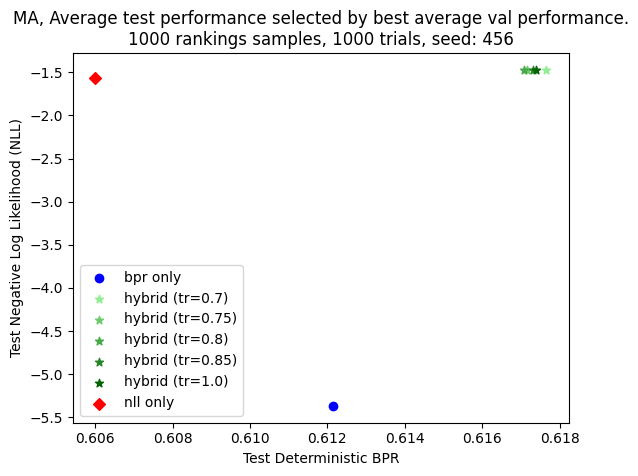

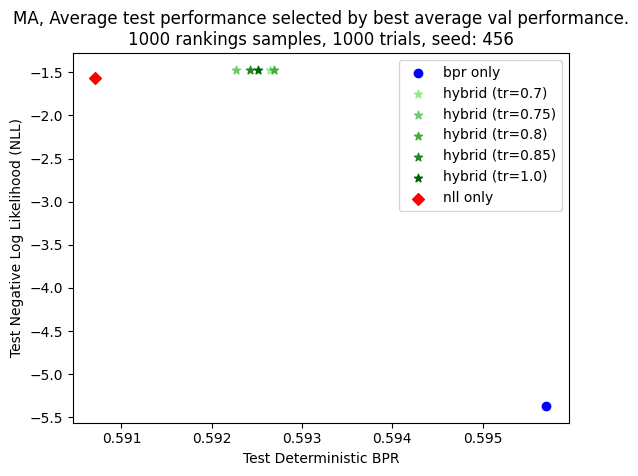

In [56]:
# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(results_df['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
            sns.violinplot(data=trial_val_bprs[idx], inner=None, color=shades_of_green[i], cut=2, bw=0.2)
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_val.png')
plt.show()

# Plot the test nll and bpr, but choose models based on the best val_det_bpr
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
            sns.violinplot(data=trial_val_bprs[idx], inner=None, color=shades_of_green[i], cut=2, bw=0.2)
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_test.png')
plt.show()

NameError: name 'loc' is not defined

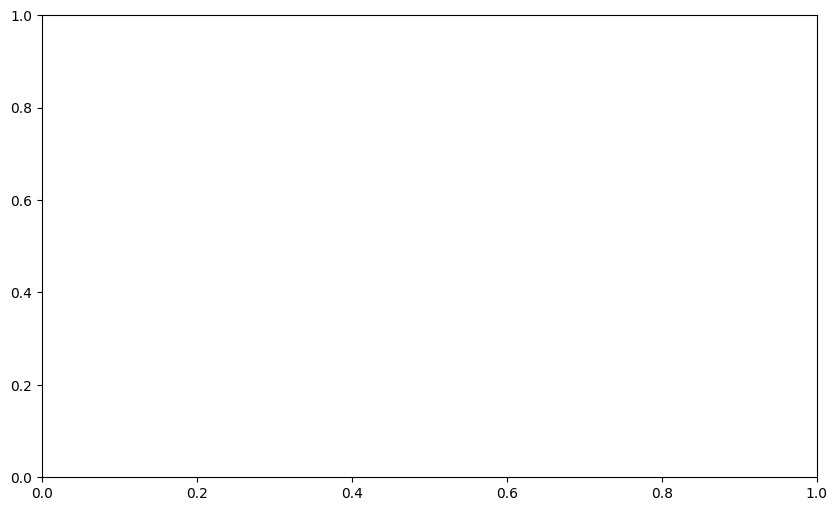

In [54]:
import seaborn as sns

# Prepare data for plotting
val_bprs = [np.mean(trial) for trial in trial_val_bprs]
test_bprs = [np.mean(trial) for trial in trial_test_bprs]

# Create a dataframe for seaborn
plot_data = pd.DataFrame({
    'avg_val_bpr': val_bprs,
    'avg_test_bpr': test_bprs,
    'val_nll': val_nlls,
    'test_nll': test_nlls,
    'bw': results_df['bw'],
    'nw': results_df['nw'],
    'tr': results_df['tr'],
    'trial_val_bprs': trial_val_bprs,
    'trial_test_bprs': trial_test_bprs
})

# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(plot_data['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
plt.figure(figsize=(10, 6))
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (plot_data['bw'] == bw) & (plot_data['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_val_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (plot_data['tr'] == tr)
            idx = plot_data[tr_mask]['avg_val_bpr'].idxmax()
            sns.violinplot(data=plot_data.loc[tr_mask, 'trial_val_bprs'].explode(), inner=None, color=shades_of_green[i], cut=2, bw=0.2)
            #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_val_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title(f'{location}, Val performance selected by val performance')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Plot the test nll and bpr, but choose models based on the best val_det_bpr
plt.figure(figsize=(10, 6))
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (plot_data['bw'] == bw) & (plot_data['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_test_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (plot_data['tr'] == tr)
            idx = plot_data[tr_mask]['avg_val_bpr'].idxmax()
            sns.violinplot(data=plot_data.loc[tr_mask, 'trial_test_bprs'].explode(), inner=None, color=shades_of_green[i], cut=2, bw=0.2)
            plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_test_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance. {num_ranking_samples} rankings samples, {num_trials} trials')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

/tmp/ipykernel_73542/3754123007.py:3: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='bw', y='avg_val_bpr', data=plot_data, inner=None, cut=2, bw=0.2)


<Axes: xlabel='bw', ylabel='avg_val_bpr'>

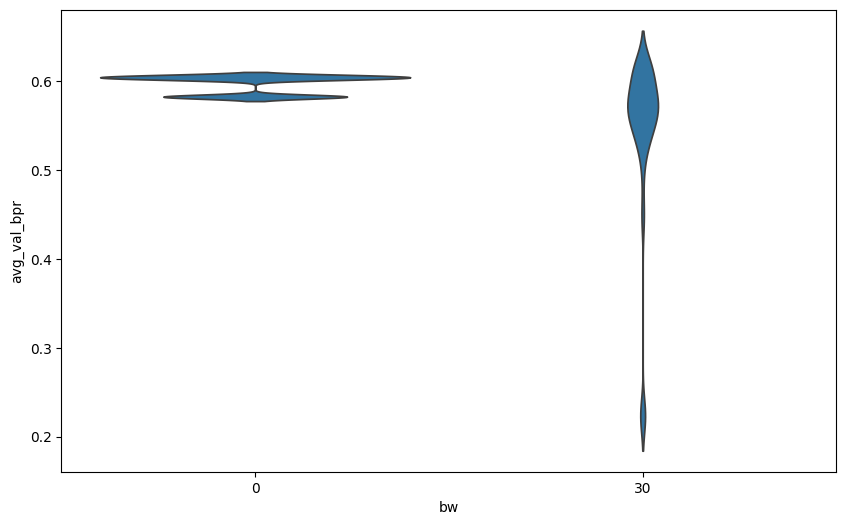

In [52]:
# makea violin plot of exploded data using x and y
plt.figure(figsize=(10, 6))
sns.violinplot(x='bw', y='avg_val_bpr', data=plot_data, inner=None, cut=2, bw=0.2)

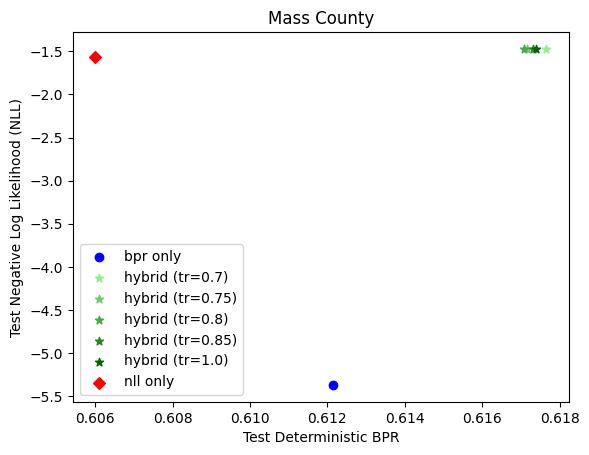

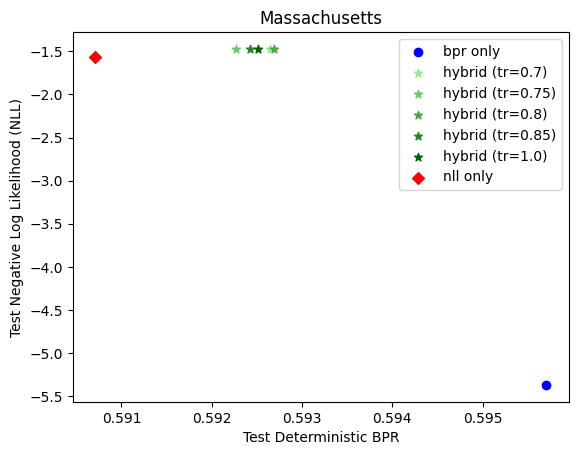

In [ ]:
# plot the final test_det_bpr and -test_nll for all models, use a different color and marker for
# bw = 30, nw=0 call this bpr only
# bw = 30, nw=1 call this hybrid
# bw = 0, nw=1 call this nll only
# don't do 0 and 0
import matplotlib.colors as mcolors

# Extract 'tr' values from results_df['param_8']
results_df['tr'] = results_df[8].apply(lambda x: float(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

# Extract 'bw' and 'nw' values from param_1 and param_2
results_df['bw'] = results_df[1].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
results_df['nw'] = results_df[2].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(results_df['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title('Massachusetts')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()
# Plot the test nll and bpr, but choose models based on the best val_det_bpr
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title('Massachusetts, Average test performance selected by best average val performance. 1000 rankings samples, 1000 trials')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

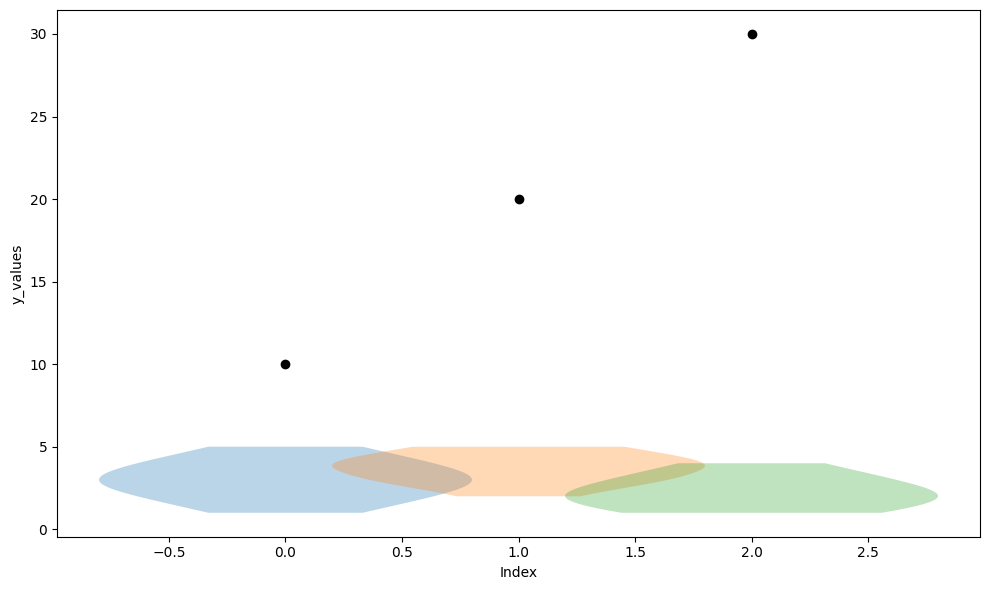

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def scatter_violin_plot(df, y_column, distribution_column, figsize=(10, 6), violin_width=0.8):
    """
    Create a scatter plot where each point has an embedded violin plot showing the distribution.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    y_column : str
        Name of the column containing y-axis values
    distribution_column : str
        Name of the column containing lists of values for violin plots
    figsize : tuple
        Figure size (width, height)
    violin_width : float
        Width scaling factor for violin plots
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each point and its distribution
    for idx, row in df.iterrows():
        y_pos = row[y_column]
        distribution = np.array(row[distribution_column])
        
        # Calculate kernel density estimation
        kde = gaussian_kde(distribution)
        x_grid = np.linspace(min(distribution), max(distribution), 100)
        density = kde(x_grid)
        
        # Scale density for visualization
        density = density / density.max() * violin_width
        
        # Create violin shape
        ax.fill_betweenx(x_grid, idx - density, idx + density, alpha=0.3)
        
        # Plot center point
        ax.scatter(idx, y_pos, color='black', zorder=3)
    
    # Customize plot
    ax.set_xlabel('Index')
    ax.set_ylabel(y_column)
    plt.tight_layout()
    
    return fig, ax

# Example usage:
import pandas as pd

# Create sample data
data = {
    'y_values': [10, 20, 30],
    'distributions': [
        [1, 2, 2, 3, 3, 3, 4, 4, 5],
        [2, 3, 3, 3, 4, 4, 4, 4, 5, 5],
        [1, 1, 2, 2, 2, 3, 3, 4]
    ]
}

df = pd.DataFrame(data)

# Create the plot
fig, ax = scatter_violin_plot(df, 'y_values', 'distributions')
plt.show()

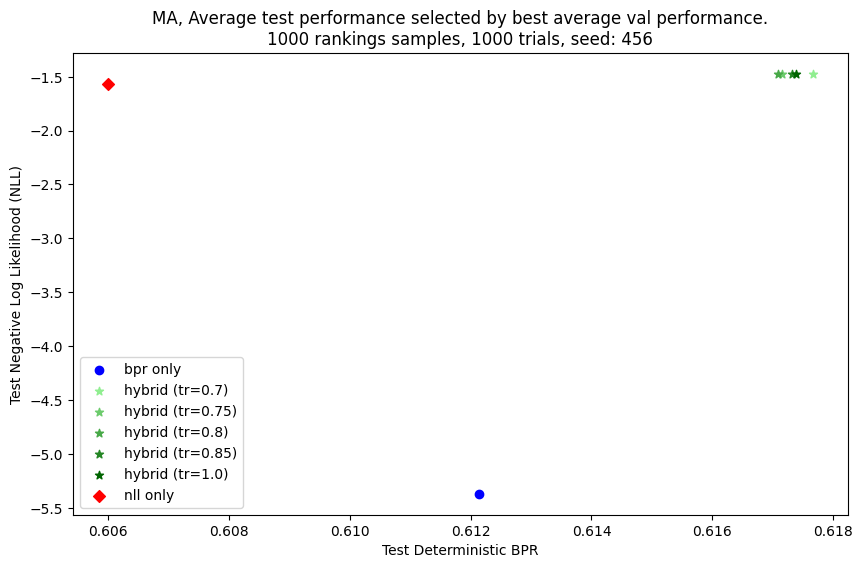

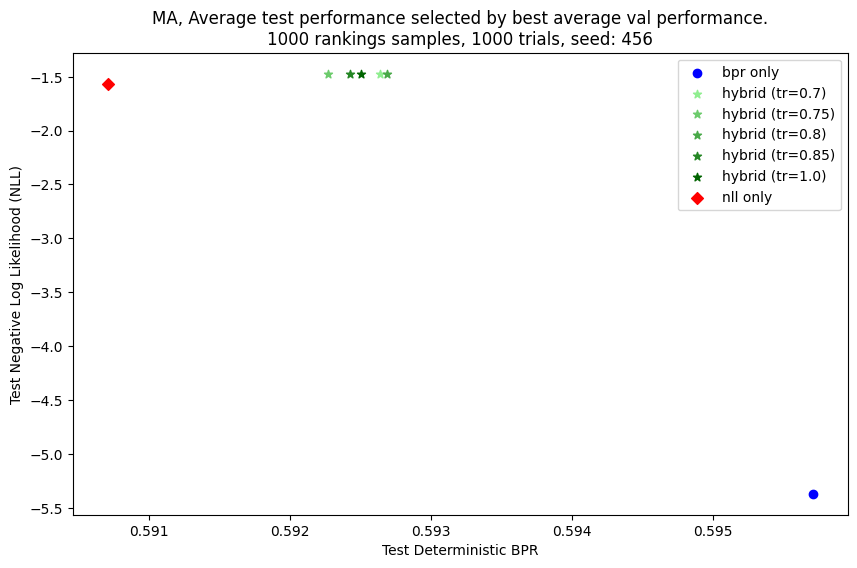

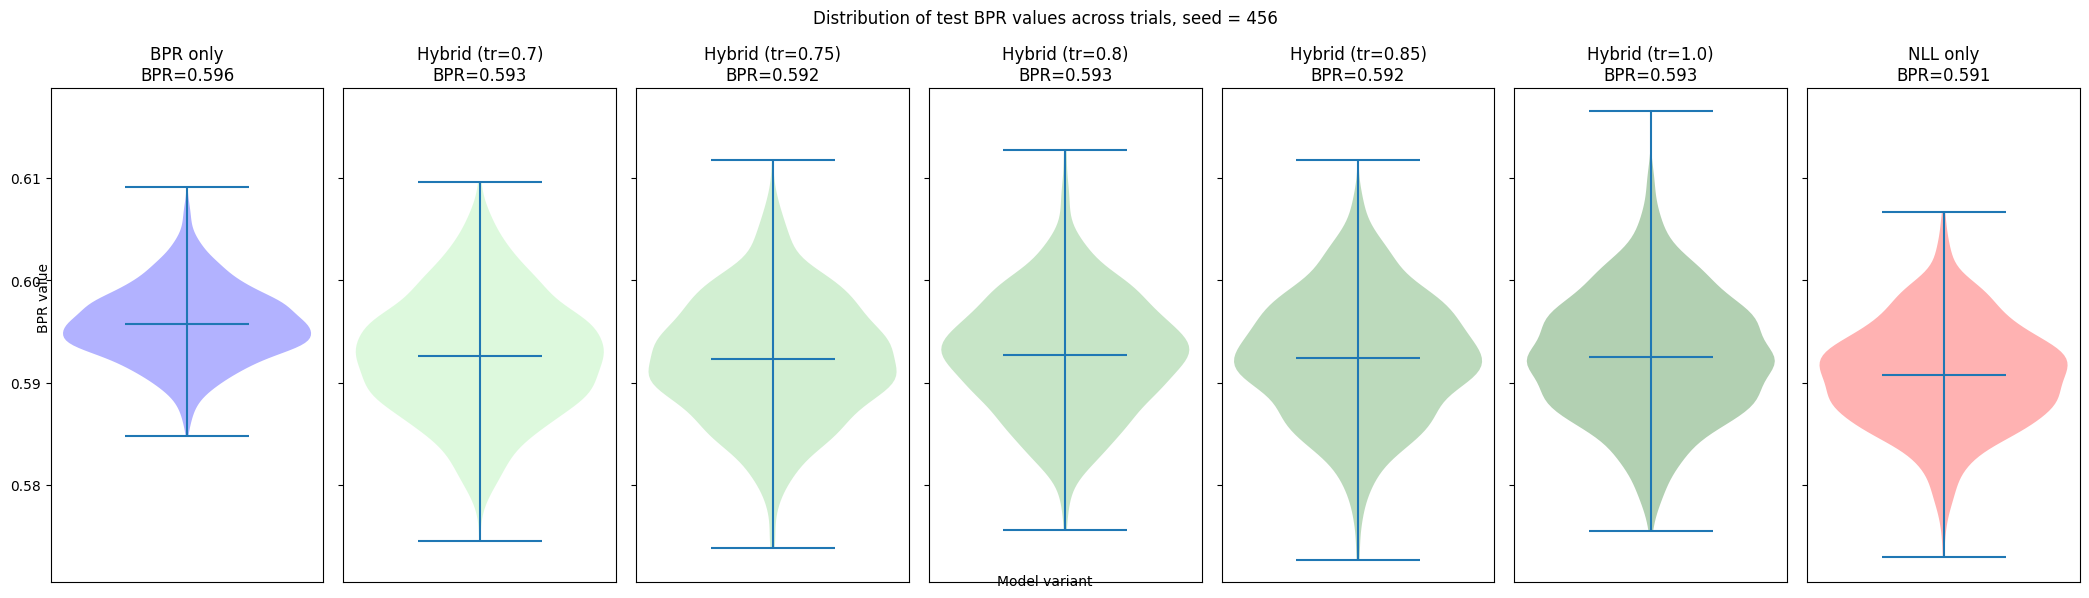

In [ ]:
# First figure: Scatter plot
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot data points (scatter only)
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], 
                        label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

plt.title(f'{location}, Average val performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_val_scatter.png')

# First figure: Scatter plot
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot data points (scatter only)
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], 
                        label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_test_scatter.png')

# Second figure: Violin plots
total_points = (
    1 +  # bpr only
    len(thresholds) +  # hybrid (one for each threshold)
    1  # nll only
)

fig2, axes = plt.subplots(1, total_points, figsize=(3*total_points, 6), sharey=True)
plot_idx = 0

# Get global min/max for y-axis limits
all_bpr_values = []
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
    elif bw == 30 and nw == 1:
        for tr in thresholds:
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test

y_min, y_max = min(all_bpr_values), max(all_bpr_values)
y_range = y_max - y_min
y_padding = y_range * 0.05

# Plot violin plots
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        ax = axes[plot_idx]
        ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
        ax.set_title(f'BPR only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
        ax.collections[0].set_facecolor(colors[(bw, nw)])
        plot_idx += 1
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'Hybrid (tr={tr})\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(shades_of_green[i])
            plot_idx += 1
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        ax = axes[plot_idx]
        ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
        ax.set_title(f'NLL only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
        ax.collections[0].set_facecolor(colors[(bw, nw)])
        plot_idx += 1

# Set common y limits for all plots
for ax in axes:
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    ax.set_xticks([])

# Set common labels for violin plots
fig2.suptitle(f'Distribution of test BPR values across trials, seed = {seed}')
fig2.text(0.5, 0.02, 'Model variant', ha='center')
fig2.text(0.02, 0.5, 'BPR value', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f'results_seed_{seed}_test_violins.png')
plt.show()